# Smoke Shop Sales Optimization

Initial data analysis and forecasting notebook.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')

In [3]:
df = pd.read_csv('../data/smoke_shop_transactions.csv', parse_dates=['date'])
df.head()

,date,product_id,product_name,category,price,quantity,revenue
0,2023-12-10,6,Coals,Accessories,10,4,40
1,2023-01-06,4,Grinder,Accessories,20,1,20
2,2023-05-21,7,CBD Gummies,Consumables,25,3,75
3,2023-04-22,7,CBD Gummies,Consumables,25,3,75
4,2023-08-22,1,Vape Pen,Devices,35,1,35


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          12000 non-null  datetime64[ns]
 1   product_id    12000 non-null  int64         
 2   product_name  12000 non-null  object        
 3   category      12000 non-null  object        
 4   price         12000 non-null  int64         
 5   quantity      12000 non-null  int64         
 6   revenue       12000 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 656.4+ KB


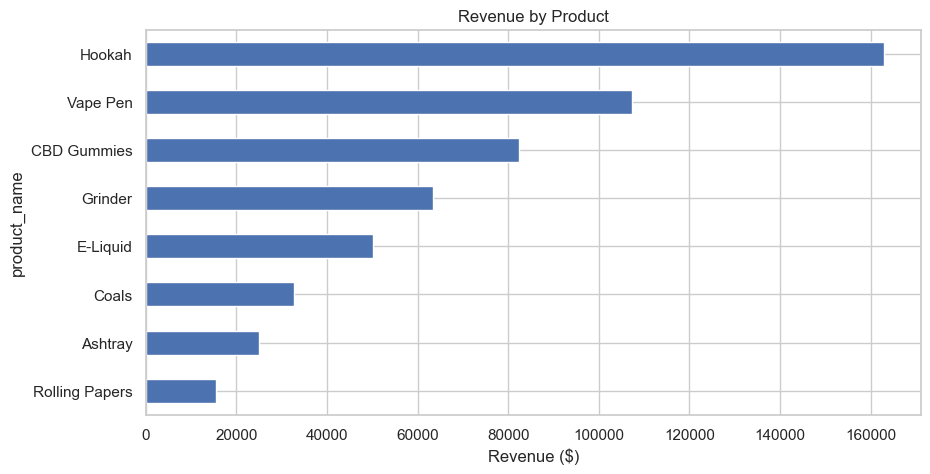

In [5]:
# Revenue by product
df.groupby('product_name')['revenue'].sum().sort_values().plot(kind='barh', figsize=(10,5), title='Revenue by Product')
plt.xlabel('Revenue ($)')
plt.show()

In [6]:
# Weekly demand

df['week'] = df['date'].dt.to_period('W').apply(lambda r: r.start_time)
df.groupby(['week', 'product_name'])['quantity'].sum().unstack().fillna(0).head()

product_name,Ashtray,CBD Gummies,Coals,E-Liquid,Grinder,Hookah,Rolling Papers,Vape Pen
week,,,,,,,,
2022-12-26,6,11,11,10,10,11,1,2
2023-01-02,72,82,48,41,45,57,52,49
2023-01-09,55,55,43,43,46,59,53,71
2023-01-16,47,62,53,53,58,64,86,63
2023-01-23,81,68,46,61,42,106,56,50


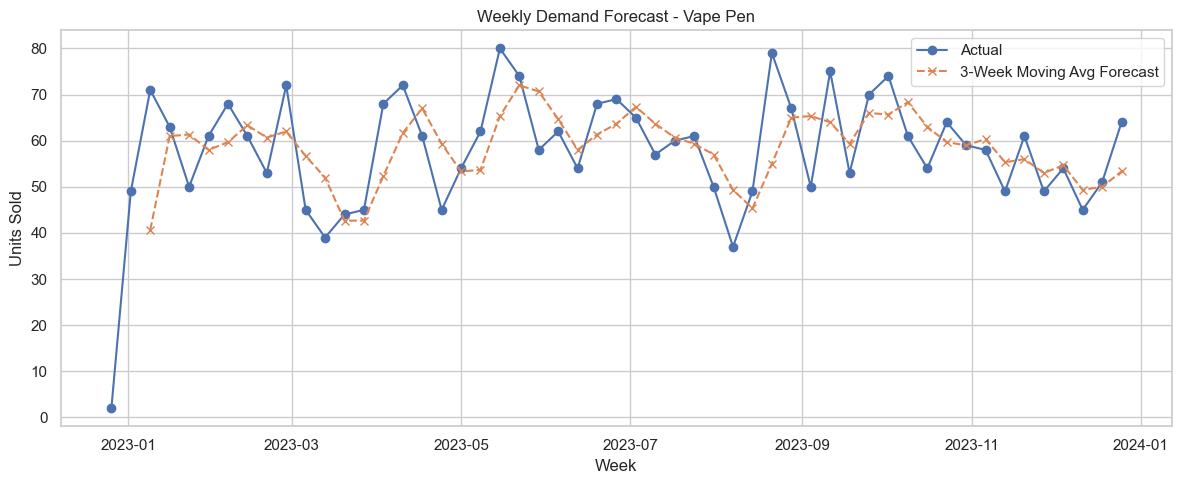

In [7]:
# Forecast weekly demand using simple moving average for a sample product
product = "Vape Pen"

# Filter to one product
weekly_product = df[df["product_name"] == product].copy()
weekly_product["week"] = weekly_product["date"].dt.to_period("W").apply(lambda r: r.start_time)
weekly_demand = weekly_product.groupby("week")["quantity"].sum().sort_index()

# Forecast using rolling average (window = 3 weeks)
weekly_demand_ma = weekly_demand.rolling(window=3).mean()

# Plot actual vs forecast
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(weekly_demand, label="Actual", marker='o')
plt.plot(weekly_demand_ma, label="3-Week Moving Avg Forecast", linestyle='--', marker='x')
plt.title(f"Weekly Demand Forecast - {product}")
plt.xlabel("Week")
plt.ylabel("Units Sold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Importing plotly failed. Interactive plots will not work.
15:20:44 - cmdstanpy - INFO - Chain [1] start processing
15:20:46 - cmdstanpy - INFO - Chain [1] done processing


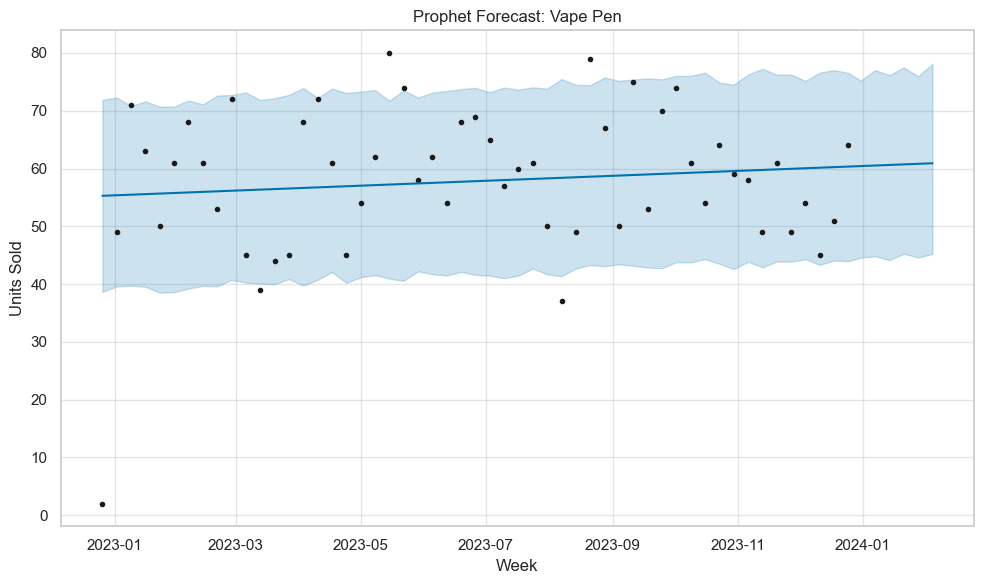

In [8]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# Select product to forecast
product = "Vape Pen"

# Prepare weekly demand data
weekly_df = df[df["product_name"] == product].copy()
weekly_df["week"] = weekly_df["date"].dt.to_period("W").apply(lambda r: r.start_time)
weekly_demand = weekly_df.groupby("week")["quantity"].sum().reset_index()
weekly_demand.columns = ["ds", "y"]  # Prophet requires 'ds' and 'y' column names

# Fit Prophet model
model = Prophet()
model.fit(weekly_demand)

# Create future dataframe (next 6 weeks)
future = model.make_future_dataframe(periods=6, freq='W')
forecast = model.predict(future)

# Plot forecast
fig = model.plot(forecast)
plt.title(f"Prophet Forecast: {product}")
plt.xlabel("Week")
plt.ylabel("Units Sold")
plt.grid(True)
plt.tight_layout()
plt.show()